# Earthquake statistics

by James Atterholt and Erin Hightower

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client = Client("IRIS")

## Import Your New Data
Make sure your script is in the same directory as your data or that you supply the right path name.

In [2]:
minlatitude=33
maxlatitude=35
minlongitude=-119
maxlongitude=-117
starttime = UTCDateTime("1970-01-01T00:00:00.000")
endtime = UTCDateTime("2022-07-01T00:00:00.000")
events = client.get_events(starttime=starttime, endtime=endtime,
                           minmagnitude=2.0,
                           minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude)
# events.plot(projection="local", resolution="f");

In [3]:
events_df = []
for event in events:
    origin = event.origins[0]
    tmp = {"time": origin.time.datetime.isoformat(), 
           "latitude": origin.latitude, 
           "longitude": origin.longitude,
           "depth_m": origin.depth, 
           "magnitude": event.magnitudes[0].mag}
    events_df.append(tmp)
events_df = pd.DataFrame(events_df)

In [4]:
df = events_df
df["LAT"] = df["latitude"]
df["LON"] = df["longitude"]
df["DEPTH"] = df["depth_m"]
df["MAG"] = df["magnitude"]
df["datetime"] = df["time"]

### Plot the earthquakes in map view

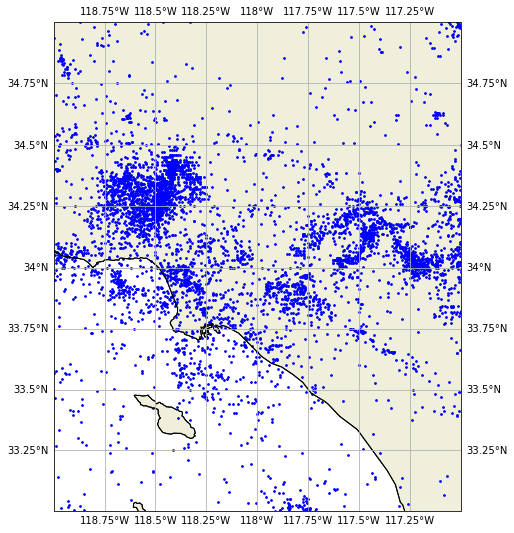

In [5]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.set_extent([-119, -117, 33, 35], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)
ax.scatter(df["LON"].values, df["LAT"].values, c='b', s=3, transform=ccrs.PlateCarree())


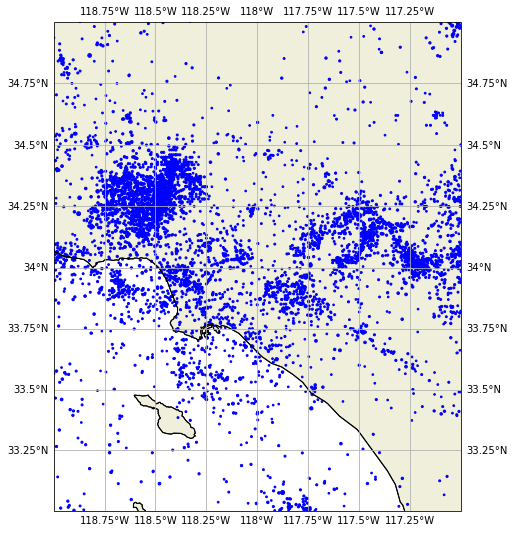

In [6]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(projection=ccrs.Mercator())
ax.set_extent([-119, -117, 33, 35], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)
ax.scatter(df["LON"].values, df["LAT"].values, c='b', s=np.exp(0.5*df["MAG"].values), transform=ccrs.PlateCarree())


## Extract and modify the data for the values you need
First we will make a copy of the dataframe, so that we can retain our original data if we need it. 

We then convert the year/month/day column and the hour/min/sec column to a datetime object that python can recognize as a date and time. Extract the year as its own column, and drop the old time columns from the new dataframe.

In [7]:
data = df.copy()
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year

### Calculate serial time
Serial time in this case is essentially continuous time give in decimal seconds, rather than year-month-day-hour-min-second format. To calculate it, we need a reference date to use as a start point. We will use the beginning year of our catalog: 1970. 

Serial time is then determine by subtracting the reference date from the datetime column in the dataframe. The new values is saved as a new variable 'serial_time'. The datetime function of pandas then has the option to convert this value to total_seconds.

In [8]:
ref_date = datetime(data.year.min(), 1, 1, 0, 0, 0, 0)
print(ref_date)

1970-01-01 00:00:00


In [24]:
data['serial_time'] = data['datetime'] - ref_date
data['serial_time'] = data['serial_time'].dt.total_seconds()
# data

# The Gutenberg Richter Law: Earthquake Magnitude-Frequency Distribution
The Gutenberg-Richter Law is one of the most fundamental empirical statistical observations in seismology. It gives the frequency of earthquake occurrence depending on the magnitude. The key observation is that large earthquakes occur much more infrequently than small earthquakes. 

Here we will take the magnitudes of the earthquakes in our catalog and count how many of them fall above a certain magnitude for each magnitude in some predefined range. Here, that range is around 2.0 to 10.0. The following cell will calculate the number of quakes in each bin (the actual data we will plot) and the predicted line of the GR law, using a and b values calculated from the data and our given magnitude of completeness. 

In [26]:
catalog_duration = data.year.max() - data.year.min()
M = data.MAG
Mc = 2.0

mag_range = np.arange(M.min(),7,0.1)
def GRcount(M,mag_range,Mc):
    num_quakes = np.zeros(mag_range.shape)
    for i in range(mag_range.shape[0]):
        num_quakes[i] = M[M >= mag_range[i]].shape[0]
    
    M_avg = np.mean(M[M > Mc])
    b = (np.log10(np.exp(1)))/(M_avg-Mc)
    a = np.log10(num_quakes[mag_range >= Mc][0])
    N = (10**(a - (b*(mag_range - Mc))))

    return num_quakes/catalog_duration, N/catalog_duration, b
        
num_quakes, N, b = GRcount(M,mag_range,Mc)


### Plot the Gutenberg-Richter Law with the data.
Hint: Make sure to make the y-axis logarithmic!

What patterns do you observe in the data?

What happens at higher magnitudes? Why do you think that happens? 

What is the largest magnitude earthquake in this catalog?

Text(0, 0.5, 'Number of Earthquakes per Year')

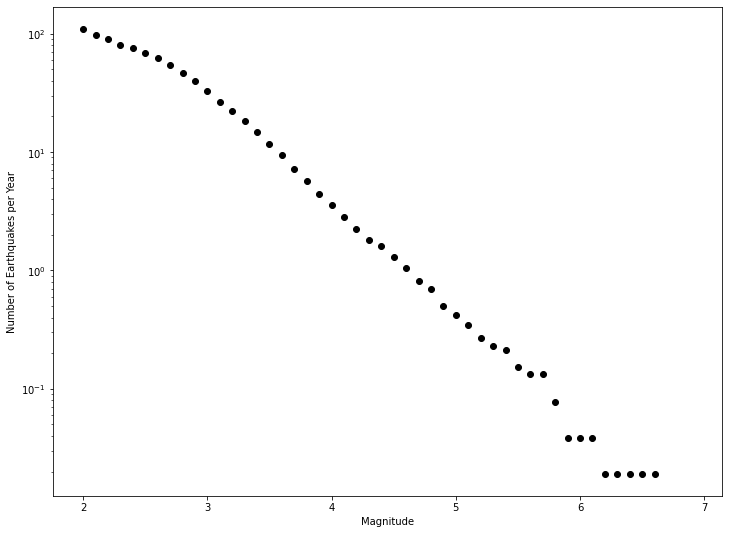

In [27]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()
# ax.plot(mag_range,N,color='red')
ax.plot(mag_range,num_quakes,marker='o',color='black',linestyle='None')
ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Number of Earthquakes per Year')


## Plotting Earthquakes with Time
Looking at the cumulative number of earthquakes with time and their magnitudes can tell us how the seismicity rate (the frequency with which earthquakes occur) is changing with time. Most of these changes happen as a result of aftershocks! 

Here we do a similar thing as before, and count the cumulative number of earthquakes with time since the start of our catalog. 

In [28]:
eq_times = data.serial_time
time_range = np.linspace(eq_times.min(),eq_times.max(),5000)

eq_count = np.zeros(time_range.shape)
for i in range(time_range.shape[0]):
    eq_count[i] = eq_times[eq_times <= time_range[i]].shape[0]


#### Plot the cumulative number of earthquakes with time
What trends do you see in the plot you made? 

Look at the years where the jumps are. Based on what you have learned about historical earthquakes in this class so far, which events do you think were responsbile for these jumps in seismic activity? Why do you think this happens?

Text(0, 0.5, 'Total Number of Earthquakes')

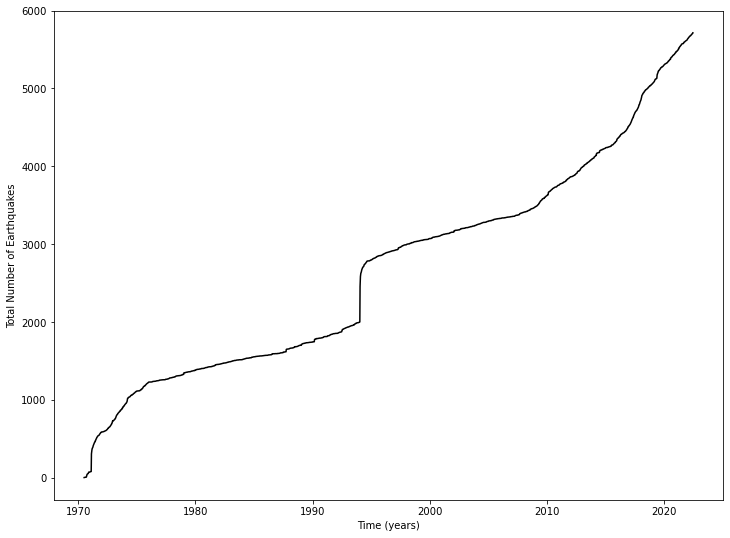

In [29]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()
ax.plot(data.year.min()+time_range/(365.25*24*60*60), eq_count, color='black')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Total Number of Earthquakes')

#### Plot the magnitudes of the earthquakes with time

What patterns do you see in the data?

Where and when are the largest earthquakes? Do you see any charactertistic patterns after those earthquakes?

Text(0, 0.5, 'Magnitude')

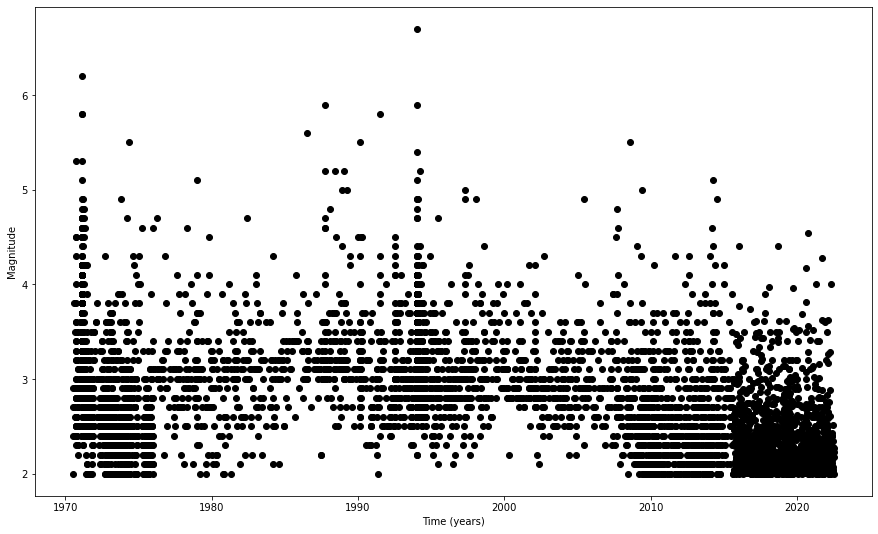

In [30]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot()
ax.plot(data.year.min()+data.serial_time/(365.25*24*60*60), data.MAG, color='black', marker='o', linestyle='None')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Magnitude')

## The Omori-Utsu Law: Aftershock Decay
The Omori Law (Omori, 1894) states that after a strong earthquake, the frequency of aftershocks decays with time on average according to a hyperbolic equation. 

$ n(t) = \frac{k}{(c+t)} $ 

This equation was later modified by Utsu (Utsu, 1961) into a power law known as the Omori-Utsu Law. The exponent p is usually around 1.0, reducing the equation to the original Omori law. However, p has been observed to have a rather large amount of variability depending on location. 

$n(t) = \frac{k}{(c+t)^p}$ 

### Zoom in to the time period from 1994 to 1996
Calculate a new serial_time column using the time of the mainshock earthquake as the reference time. 

In [43]:
data_afsh = data[(data.year >= 1994) & (data.year < 1995)]
mainshock_time = data_afsh[data_afsh.MAG == data_afsh.MAG.max()]['serial_time'].values #datetime(1994, 1, 17, 12, 30, 55, 390) 
data_afsh['t_since_eq'] = data_afsh['serial_time'] - mainshock_time
data_afsh.drop(data_afsh[data_afsh['t_since_eq'] < 0].index, inplace=True)
# data_afsh

/var/folders/gc/lpnp82h92tv35c_7v97w97cm0000gn/T/ipykernel_19327/2954165421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_afsh['t_since_eq'] = data_afsh['serial_time'] - mainshock_time
/Users/weiqiang/.local/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [44]:
eq_times_afsh = data_afsh.serial_time
time_range_afsh = np.linspace(eq_times_afsh.min(),eq_times_afsh.max(),5000)

eq_count_afsh = np.zeros(time_range_afsh.shape)
for i in range(time_range_afsh.shape[0]):
    eq_count_afsh[i] = eq_times_afsh[eq_times_afsh <= time_range_afsh[i]].shape[0]

eq_count_afsh

array([  1.,  29.,  58., ..., 792., 792., 793.])

### Calculate Omori's Law using the new 't_since_eq' as the t variable

n_total will give you the total number of earthquakes with time since the mainshock. 

In [45]:
t = data_afsh.t_since_eq.values/(24*60*60)
k = 1.3
c = 0.09 #12
p = 1.18 #0.08
n = k/((c + t)**p)

n_total = np.cumsum(n)

# n_total

Text(0, 0.5, 'Magnitude')

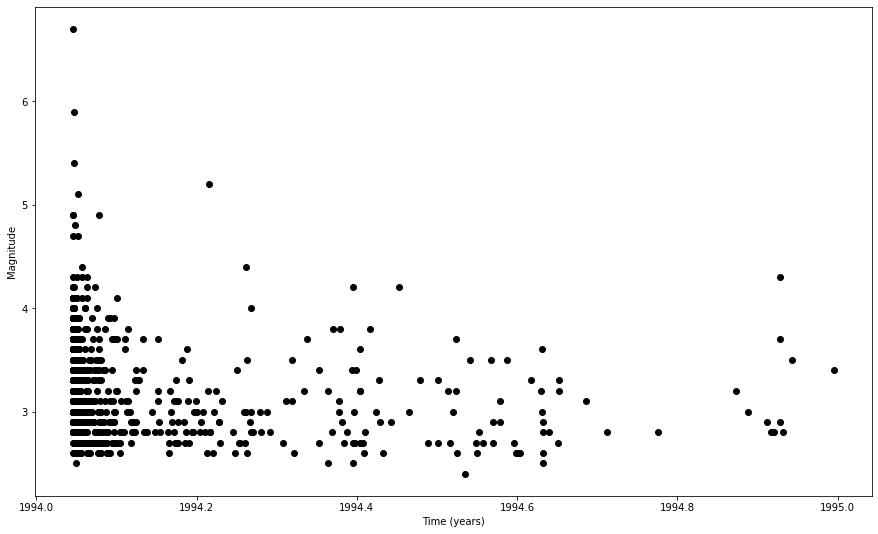

In [46]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot()
ax.plot(data.year.min()+data_afsh.serial_time/(365.25*24*60*60), data_afsh.MAG, color='black', marker='o', linestyle='None')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Magnitude')

Text(0, 0.5, 'Total Number of Earthquakes')

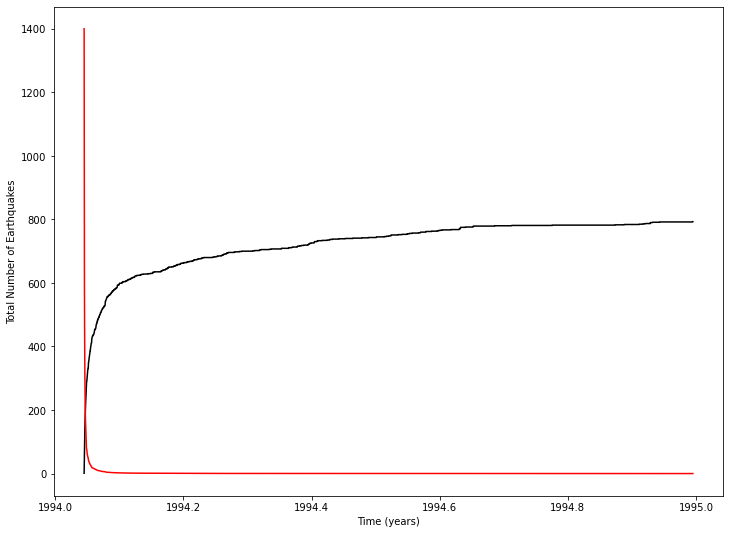

In [47]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot()
ax.plot(data.year.min()+time_range_afsh/(365.25*24*60*60), eq_count_afsh, color='black')
ax.plot(data.year.min()+(mainshock_time + data_afsh.t_since_eq)/(365.25*24*60*60), n_total, color='red')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Total Number of Earthquakes')